In [12]:
import os
import numpy as np
import pandas as pd
import ants
from tqdm import tqdm

from matplotlib import pyplot as plt
from scipy.stats import ttest_rel

In [13]:
ants.__version__

'0.6.1'

In [14]:
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix

In [55]:
def max_voxel_coords(volume):
    """
    Given a 3D NumPy array `volume`, return the (x, y, z) index
    of its maximum element.

    Parameters
    ----------
    volume : np.ndarray
        3D array of shape (X, Y, Z).

    Returns
    -------
    coords : tuple of int
        The (x, y, z) indices of the maximum value in `volume`.
    """
    # Find the flat index of the maximum
    flat_idx = np.argmax(volume)
    # Convert flat index into 3D coordinates
    return tuple(np.unravel_index(flat_idx, volume.shape))

In [56]:
indir = '../Data/things/fmriprep2'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs_orig.sort()
n_orig = len(subs_orig)

In [76]:
#'../Data/StudyForrest/ensembles_last_CVAE/refactored-THINGS-loc-v3-fixed-nopreclean/'
#'../Data/StudyForrest/ensembles_last_CVAE/refactored-THINGS-loc-v4-fixed-scrub/'
#'../Data/StudyForrest/ensembles_last_CVAE/refactored-THINGS-loc-v5-fixed-regress/'
#'../Data/StudyForrest/ensembles_last_CVAE/refactored-THINGS-loc-v6-fixed-ScrubRegress/'

ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
#analysis_name = 'refactored-THINGS-loc-v5-fixed-regress'
#analysis_name = 'refactored-THINGS-loc-v3-fixed-nopreclean'
#analysis_name = 'refactored-THINGS-loc-v3-fixed-nopreclean'
#analysis_name = '162-refac-baseline-3-1-THINGS-loc-nopreclean'
#analysis_name = '162-refac-baseline-1-THINGS-TC-nopreclean'
#analysis_name = '162-refac-baseline-3-1-THINGS-loc-nopreclean' 
#analysis_name = '162-refac-baseline-1-THINGS-beta-1e-5'
#analysis_name = '162-refac-baseline-1-THINGS-TC-nopreclean'

analysis_name = 'DeepCor-things-nopreclean-beta-1e-5'

ofdir = os.path.join(ofdir_root,analysis_name)

In [77]:
# conf_fn_format = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')
# events_fn_temp = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')

## Make indiv ROIs Face

In [78]:
rvec = [1,2,3,4,5,6]

In [79]:
# check_exists = [[os.path.exists(os.path.join(ofdir,f'contrast_face_S{s}_R{r}_compcor.nii.gz')) for s in range(3)] for r in rvec]
# print((np.array(check_exists)==False).sum())
# check_exists

In [80]:
roi_dir = '../Data/things/ROIs-indiv'

In [81]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0
    
do_make_rois = False
if do_make_rois:
    atype = 'contrast_face'
    kind = 'compcor'
    sphere_dim = 5
    nvoxels = 100
    
    files = [os.path.join(ofdir,file) for file in os.listdir(ofdir) if all((file.startswith(f'{atype}_'),file.endswith(f'_{kind}.nii.gz')))]
    files.sort()
    
    arr = np.array([ants.image_read(file).numpy() for file in files]).mean(axis=0)
    xyz = max_voxel_coords(arr)
    im = ants.image_read(files[0]).new_image_like(arr)
    im.to_filename(os.path.join(ofdir,f'{atype}_{kind}_grandavg.nii.gz'))

    temp = ants.image_read('../Misc/single_subj_T1.nii')
    temp.plot_ortho(im,flat=True,xyz=xyz)
    
    im_sphere = im.new_image_like(sphere(im.shape,sphere_dim,xyz)*1.0)
    im_sphere.to_filename(os.path.join(ofdir,'sphere.nii'))
    print(im_sphere.numpy().sum())
    temp.plot_ortho(im_sphere,flat=True,xyz=xyz)
    
    for s in range(3):
        sphere = ants.image_read(os.path.join(ofdir,'sphere.nii'))
        im_c = [ants.image_read(os.path.join(ofdir,f'{atype}_S{s}_R{r}_{kind}.nii.gz')) for r in rvec]
        im_c = im_c[0].new_image_like(np.array([val.numpy() for val in im_c]).mean(axis=0))
    
        critval = np.sort(im_c.numpy()[sphere.numpy()==1].flatten())[-nvoxels-1]
        indiv_roi = (im_c.numpy()>critval) * sphere.numpy()==1
        im_indiv_roi = im_c.new_image_like(indiv_roi)
        im_indiv_roi.to_filename(os.path.join(roi_dir,f'FFA-ROI-S{s}.nii'))
        
    files = [os.path.join(roi_dir,file) for file in os.listdir(roi_dir) if file.startswith('FFA-ROI')]
    ims = [ants.image_read(file) for file in files]
    ims[0].new_image_like(np.array([im.numpy() for im in ims]).sum(axis=0)).to_filename(os.path.join(roi_dir,'GroupMap-FFA.nii'))

In [82]:
res = np.zeros((len(rvec),len(subs_orig),3))
for s in range(3):
    for r in rvec:
        # im_p = ants.image_read(os.path.join(ofdir,f'contrast_face_S{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'contrast_face_S{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'contrast_face_S{s}_R{r}_deepcor.nii.gz'))
        
        im_p = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_deepcor.nii.gz'))

        
        roi = ants.image_read(os.path.join(roi_dir,f'FFA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()
face_res = res.copy()
np.save(f'../Data/corr2face_{analysis_name}.npy',face_res)

In [83]:
res = np.zeros((len(rvec),len(subs_orig),3))
for s in range(3):
    for r in rvec:
        im_p = ants.image_read(os.path.join(ofdir,f'contrast_face_S{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'contrast_face_S{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'contrast_face_S{s}_R{r}_deepcor.nii.gz'))
        
        # im_p = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'corr2face_S{s}_R{r}_deepcor.nii.gz'))

        
        roi = ants.image_read(os.path.join(roi_dir,f'FFA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()

face_res = res.copy()
np.save(f'../Data/contrast_face_{analysis_name}.npy',face_res)

[2.72821556 3.0269917  4.31856871]
improvement: 432.0%


Ttest_relResult(statistic=1.4647007765511175, pvalue=0.28060337655578416)

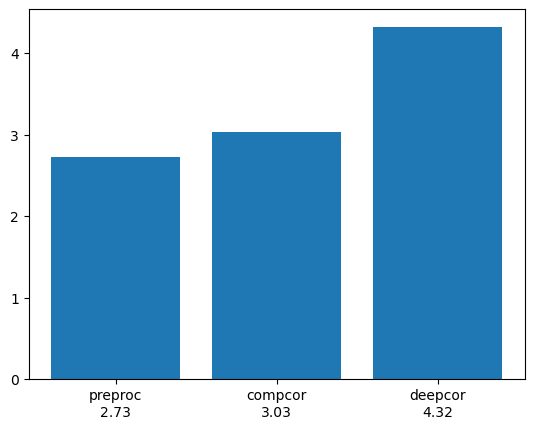

In [84]:
ys = res.mean(axis=0).mean(axis=0)
xs = [0,1,2]
plt.bar(xs,ys)
lbls = ['preproc','compcor','deepcor'];
lbls = [lbls[i]+'\n'+f'{ys[i]:.2f}' for i in range(len(ys))];
plt.xticks(xs,labels=lbls);

avg = res.mean(axis=0).mean(axis=0)
print(avg)
d1=avg[1]-avg[0]
d2=avg[2]-avg[0]
improvement = ((d2/d1)-1)*100
improvement = improvement.round()
print('improvement: {}%'.format(improvement))
ttest_rel(res.mean(axis=0)[:,2],res.mean(axis=0)[:,1])

## Make indiv ROIs Place

In [85]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0


do_make_rois = False
if do_make_rois:
    atype = 'contrast_place'
    kind = 'compcor'
    sphere_dim = 5
    nvoxels = 100
    
    files = [os.path.join(ofdir,file) for file in os.listdir(ofdir) if all((file.startswith(f'{atype}_'),file.endswith(f'_{kind}.nii.gz')))]
    files.sort()
    
    arr = np.array([ants.image_read(file).numpy() for file in files]).mean(axis=0)
    xyz = max_voxel_coords(arr)
    im = ants.image_read(files[0]).new_image_like(arr)
    im.to_filename(os.path.join(ofdir,f'{atype}_{kind}_grandavg.nii.gz'))
    
    temp = ants.image_read('../Misc/single_subj_T1.nii')

    temp.plot_ortho(im,flat=True,xyz=xyz)
    im_sphere = im.new_image_like(sphere(im.shape,sphere_dim,xyz)*1.0)
    im_sphere.to_filename(os.path.join(ofdir,'sphere.nii'))
    print(im_sphere.numpy().sum())
    temp.plot_ortho(im_sphere,flat=True,xyz=xyz)
    
    for s in range(3):
        im_sphere = ants.image_read(os.path.join(ofdir,'sphere.nii'))
        im_c = [ants.image_read(os.path.join(ofdir,f'{atype}_S{s}_R{r}_{kind}.nii.gz')) for r in [1,2]]
        im_c = im_c[0].new_image_like(np.array([val.numpy() for val in im_c]).mean(axis=0))
    
        critval = np.sort(im_c.numpy()[im_sphere.numpy()==1].flatten())[-nvoxels-1]
        indiv_roi = (im_c.numpy()>critval) * im_sphere.numpy()==1
        im_indiv_roi = im_c.new_image_like(indiv_roi)
        im_indiv_roi.to_filename(os.path.join(roi_dir,f'PPA-ROI-S{s}.nii'))
        
    files = [os.path.join(roi_dir,file) for file in os.listdir(roi_dir) if file.startswith('PPA-ROI')]
    ims = [ants.image_read(file) for file in files]
    ims[0].new_image_like(np.array([im.numpy() for im in ims]).sum(axis=0)).to_filename(os.path.join(roi_dir,'GroupMap-PPA.nii'))

In [86]:
res = np.zeros((len(rvec),len(subs_orig),3))
for s in range(3):
    for r in rvec:
        # im_p = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_deepcor.nii.gz'))
        
        im_p = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_deepcor.nii.gz'))

        roi = ants.image_read(os.path.join(roi_dir,f'PPA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()

place_res = res.copy()
np.save(f'../Data/corr2place_{analysis_name}.npy',place_res)        

In [87]:
res = np.zeros((len(rvec),len(subs_orig),3))
for s in range(3):
    for r in rvec:
        im_p = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_preproc.nii.gz'))
        im_c = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_compcor.nii.gz'))
        im_d = ants.image_read(os.path.join(ofdir,f'contrast_place_S{s}_R{r}_deepcor.nii.gz'))
        
        # im_p = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_preproc.nii.gz'))
        # im_c = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_compcor.nii.gz'))
        # im_d = ants.image_read(os.path.join(ofdir,f'corr2place_S{s}_R{r}_deepcor.nii.gz'))

        roi = ants.image_read(os.path.join(roi_dir,f'PPA-ROI-S{s}.nii'))
        indiv_roi = roi.numpy()==1

        res[r-1,s,0] = im_p.numpy()[indiv_roi].mean()
        res[r-1,s,1] = im_c.numpy()[indiv_roi].mean()
        res[r-1,s,2] = im_d.numpy()[indiv_roi].mean()

place_res = res.copy()
np.save(f'../Data/contrast_place_{analysis_name}.npy',place_res)

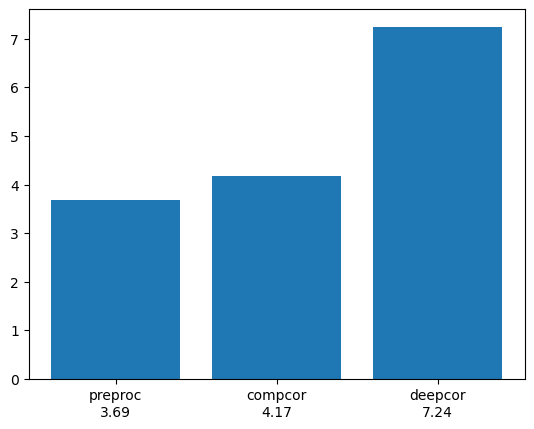

In [88]:
ys = res.mean(axis=0).mean(axis=0)
xs = [0,1,2]
plt.bar(xs,ys)
lbls = ['preproc','compcor','deepcor'];
lbls = [lbls[i]+'\n'+f'{ys[i]:.2f}' for i in range(len(ys))];
plt.xticks(xs,labels=lbls);

In [89]:
avg = res.mean(axis=0).mean(axis=0)
print(avg)
d1=avg[1]-avg[0]
d2=avg[2]-avg[0]
improvement = ((d2/d1)-1)*100
improvement = improvement.round()
print('improvement: {}%'.format(improvement))
ttest_rel(res.mean(axis=0)[:,2],res.mean(axis=0)[:,1])

[3.69112198 4.17408306 7.24183713]
improvement: 635.0%


Ttest_relResult(statistic=6.176260511034593, pvalue=0.025227166509109285)

In [90]:
res.mean(axis=0)

array([[ 2.60697361,  3.23338525,  5.98298343],
       [ 5.738     ,  6.01868947, 10.06051715],
       [ 2.72839234,  3.27017446,  5.68201081]])

In [91]:
res[:,:,2]-res[:,:,0]

array([[ 3.93943465,  5.05619764,  5.73463511],
       [ 2.39205003,  3.29210663,  3.42434072],
       [ 2.68365288,  4.84466362,  3.43819022],
       [ 2.82243276,  3.54888582, -1.09793448],
       [ 5.46921313,  4.76885033,  5.13947737],
       [ 2.94927549,  4.4243989 ,  1.08300185]])

In [92]:
mot = np.zeros((len(rvec),len(subs_orig)))
for s in range(3):
    for r in rvec:
        sub = subs_orig[s]
        sess_name = 'ses-localizer2' if sub=='sub-01' else 'ses-localizer1'
        fn = os.path.join(indir,sub,sess_name,'func',f'{sub}_{sess_name}_task-6cat_run-{r:02d}_desc-confounds_timeseries.tsv')
        df = pd.read_csv(fn,delimiter='\t')
        fd = df['framewise_displacement'][1::]
        #mot[r-1,s]=fd.sum()
        mot[r-1,s]=fd.mean()
        #mot[r-1,s]=(fd>.5).sum()
        #mot[r-1,s]=fd.max()
print(mot)
#np.save('../Data/mot_thinfs.npy',mot)

[[0.1476602  0.08972336 0.13245185]
 [0.12066152 0.08635524 0.10644609]
 [0.13840533 0.11635463 0.10759692]
 [0.12534277 0.07206001 0.10515223]
 [0.14504773 0.08938747 0.12572758]
 [0.13627725 0.10477207 0.12727433]]


-0.7342494411776557


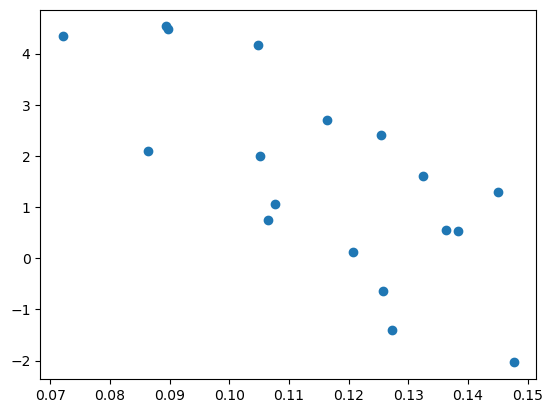

In [93]:
vals = face_res[:,:,2]-face_res[:,:,0]
print(np.corrcoef(mot.flatten(),vals.flatten())[0,1])
plt.scatter(mot.flatten(),vals.flatten())

0.04324413565699934


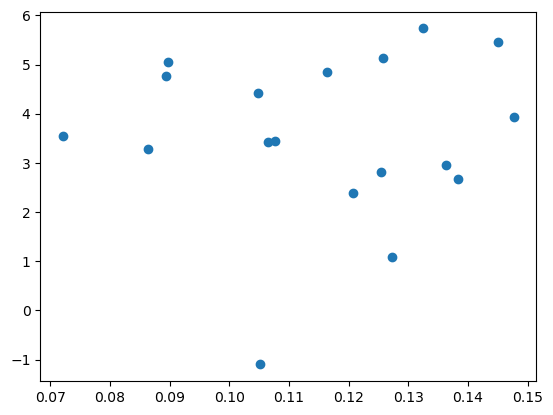

In [94]:
vals = place_res[:,:,2]-place_res[:,:,0]
print(np.corrcoef(mot.flatten(),vals.flatten())[0,1])
plt.scatter(mot.flatten(),vals.flatten())